In [1]:
import pickle
import pandas as pd
import os
import glob
from IPython.display import display
import matplotlib.pyplot as plt
import re
import numpy as np

Reading the files with Market Iterations: These are for multiple auctions in one run


In [ ]:
def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

In [ ]:
# Directing to the path where the results are stored adn read all the pickle files (Market 0 to end market), extracting the market times
# and storing the data in a list of dictionaries. The list is then converted to a DataFrame for easier visualization.
current_dir = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_dir, ".."))
folder_path = os.path.join(
    parent_folder,
    "results",
    "modified_bidbudget_toulouse_case3_withC_cap5_withReturn_3_highcap_fisher_b-50.0_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250204_111131",
    "results"
)


fisher_files = sorted(glob.glob(os.path.join(folder_path, "fisher_data_*.pkl")))
fisher_after_files = sorted(glob.glob(os.path.join(folder_path, "fisher_data_after_*.pkl")))

# Extract the market auction time from filenames
def extract_time(filename):
    return int(filename.split("_")[-1].split(".")[0])  # Extracts the number from fisher_data_X.pkl


fisher_data_list = []
after_fisher_data_list = []

# Iterate over paired files
for fisher_file, fisher_after_file in zip(fisher_files, fisher_after_files):
    fisher_data = read_pickle_file(fisher_file)
    end_of_market_data = read_pickle_file(fisher_after_file)

    if fisher_data is None or end_of_market_data is None:
        continue  # Skip if reading failed

    market_time = extract_time(fisher_file)

    # Extract necessary data from Fisher Market (Before Transactions)
    prices = fisher_data["prices"]
    goods_list = fisher_data["goods_list"]

    # Extract necessary data from End of Market (After Transactions)
    market_data = end_of_market_data["market_data"]
    agents_data = end_of_market_data["agents_data"]

    # Extract market-level data
    end_capacities = market_data["capacity"]
    initial_capacities = market_data["original_capacity"]
    end_prices = market_data["prices"]  # Prices after transactions (if they change)

    print(f"\n🔎 Processing Market Time: {market_time}")
    print(f"  📌 Found {len(fisher_data['desired_goods'])} agents")

    for agent, agent_data in fisher_data["desired_goods"].items():
        desired_indx = agent_data['desired_transit_edges_idx'][0]  # Directly access

        try:
            # Data before transactions (Fisher Market)
            fisher_data_list.append({
                "Market_Time": market_time,
                "Agent": agent,
                "Edge_Index": desired_indx,
                "Price": prices[desired_indx],  # Price before transaction
                "Initial_Capacity": initial_capacities[desired_indx],  # Starting capacity
                "Good": goods_list[desired_indx][1],
                "Data_Type": "Fisher"
            })

            # Extract agent-specific information after the market transaction
            agent_final_allocation = agents_data[agent].get("final_allocation", {})
            agent_payment = agents_data[agent].get("payment", 0)
            agent_valuation = agents_data[agent].get("valuation", {})

            # Data after transactions (After Fisher Market)
            after_fisher_data_list.append({
                "Market_Time": market_time,
                "Agent": agent,
                "Edge_Index": desired_indx,
                "Price": end_prices[desired_indx],  # Final price after auction
                "End_Capacity": end_capacities[desired_indx],  # Capacity after auction
                "Good": goods_list[desired_indx][1],
                "Final_Goods_allocated": agents_data[agent]["agent_goods_list"],  # Final goods allocated
                "Final_goods_vector": agent_final_allocation,
                "Payment": agent_payment,
                "Data_Type": "After_Fisher"
            })
        except KeyError as e:
            print(f"    ❌ Skipping {agent}: Key {e} not found in dataset!")

# Create DataFrames
df_fisher = pd.DataFrame(fisher_data_list)
df_after_fisher = pd.DataFrame(after_fisher_data_list)

# ## uncomment below if you want to see the entire dataframe
# # pd.set_option('display.max_rows', None)  # Show all rows
# # pd.set_option('display.max_columns', None)  # Show all columns
# # pd.set_option('display.width', 1000)  # Adjust width to prevent line breaks
# # pd.set_option('display.max_colwidth', None)  # Prevent column truncation
# # display(df)



In [ ]:
# Display high-level structure of data
print("📊 Summary of Fisher Market Data Structure:")
print("High-level data from End of Market:", list(end_of_market_data.keys()))
print("High-level data from Fisher Market:", list(fisher_data.keys()))

# DataFrame summaries
print("\n🗂 Fisher Market Data Overview:")
display(df_fisher.info())
display(df_fisher.sample(10))

print("\n🗂 After Fisher Market Data Overview:")
display(df_after_fisher.info())
display(df_after_fisher.sample(10))


In [ ]:
# Ensure Market_Time is an integer for proper sorting
df_fisher['Market_Time'] = df_fisher['Market_Time'].astype(int)

# Split "Good" into "Sector" and "Request_Time"
df_fisher[['Sector', 'Request_Time']] = df_fisher['Good'].str.split('_', expand=True)

# Convert Request_Time to integer
df_fisher['Request_Time'] = df_fisher['Request_Time'].astype(int)

# Group by Sector, Request_Time, and Market_Time while counting the number of agents
sector_request_counts = (
    df_fisher.groupby(['Sector', 'Request_Time', 'Market_Time'])['Agent']
    .count()
    .reset_index()
    .rename(columns={'Agent': 'Num_Agents'})
)

# Sort the DataFrame by Market_Time (ascending), Request_Time, and Sector (both descending)
sector_request_counts_sorted = sector_request_counts.sort_values(
    by=["Market_Time", "Request_Time", "Sector"], ascending=[True, True, True]
)

# Display DataFrame
pd.set_option('display.max_rows', None)
display(sector_request_counts_sorted)



## Plot Performance Data

In [ ]:
current_dir = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_dir, ".."))
current_dir = os.getcwd()

new_folder_path = os.path.join(parent_folder, "results", "capacity_study")
file_list = [f.path for f in os.scandir(new_folder_path) if f.is_dir()]


df_list = []

for file in file_list:
    folder_path = os.path.join(parent_folder, "results", file, "results")
    csv_file_path = os.path.join(folder_path, 'market_performance_table.csv')
    
    try:
        df_csv = pd.read_csv(csv_file_path)
        df_csv["File"] = file  # column to track file origin
        capacity = int(file.split('_cap')[1].split('_')[0])
        df_csv["Capacity"] = capacity
        df_list.append(df_csv)
    except FileNotFoundError:
        print(f"File not found: {csv_file_path}")
    except pd.errors.EmptyDataError:
        print(f"File is empty: {csv_file_path}")

# Concatenate all DataFrames

pd.set_option('display.max_rows', None) 
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df = combined_df.sort_values(by=["Capacity", "Number_Agents"])
    # display(combined_df.head())
    display(combined_df)
else:
    print("No data was loaded.")

 

In [ ]:
# Plotting the data
plt.figure(figsize=(6, 6))
# plt.title("Market Performance by Capacity")
plt.ylabel("Number of Iterations", fontsize=12)
plt.xlabel("Number of Agents", fontsize=12)
# plt.yticks(range(0, combined_df["Number_Interations"].max() + 10, 10))
plt.grid()
capacities = [100,75,50,25]
combined_df = combined_df.sort_values(by=["Number_Agents", "Capacity"])

colors = {14: 'blue', 10: 'green', 7: 'orange', 4: 'red'}
# combined_df = combined_df.sort_values(by="Capacity")
for capacity in combined_df["Capacity"].unique():
    if capacity == 14:
        cap = 100
    elif capacity == 10:
        cap = 75
    elif capacity == 7:
        cap = 50
    elif capacity == 4:
        cap = 25
    subset = combined_df[combined_df["Capacity"] == capacity]
    plt.plot(subset["Number_Agents"], subset["Number_Interations"], label=f"Capacity {cap}%", marker='o', color=colors[capacity])

plt.legend()
current_dir = os.getcwd()
plt.savefig(f"{current_dir}/plots/nagents_niter.png")

In [ ]:
# Plotting the data
plt.figure(figsize=(12, 6))
plt.title("Market Performance by Capacity")
plt.ylabel("Number of Iterations")
plt.xlabel("Number Contested Routes")
plt.grid()
for capacity in combined_df["Capacity"].unique():
    if capacity == 14:
        cap = 100
    elif capacity == 10:
        cap = 75
    elif capacity == 7:
        cap = 50
    elif capacity == 4:
        cap = 25
    subset = combined_df[combined_df["Capacity"] == capacity]
    plt.plot(subset["Number_Contested_Routes"], subset["Number_Interations"], label=f"Capacity {cap}", marker='o')

plt.legend()



In [ ]:
# Plotting the data
plt.figure(figsize=(6, 6))
# plt.title("Market Performance by Capacity")
plt.ylabel("Number of Iterations")
plt.xlabel("Runtime (seconds)")
plt.grid()
for capacity in combined_df["Capacity"].unique():
    if capacity == 13:
        cap = 100
    elif capacity == 10:
        cap = 75
    elif capacity == 7:
        cap = 50
    elif capacity == 4:
        cap = 25
    subset = combined_df[combined_df["Capacity"] == capacity]
    subset = subset.sort_values(by="Run_Time")
    plt.plot(subset["Run_Time"], subset["Number_Interations"], label=f"Capacity {cap}%", marker='o')
    # plt.plot(subset["Number_Interations"], subset["Run_Time"], label=f"Capacity {cap}%", marker='o')
    # plt.plot(subset["Run_Time"], subset["Number_Interations"], label=f"Capacity {capacity}", marker='o')

plt.legend()
plt.savefig(f"{current_dir}/plots/runtime_niter.png")

# Beta Study
## Reading multiple market performance files for every case adn every auction

In [6]:
current_dir = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_dir, ".."))
new_folder_path = os.path.join(parent_folder, "results", "beta_study_convergence")
folder_list = [f.path for f in os.scandir(new_folder_path) if f.is_dir()]


In [7]:
df_list = []
df_method = []
for file in folder_list:
    folder_path = os.path.join(parent_folder, "results", file, "results")
    csv_file_path = os.path.join(folder_path, 'market_performance_table.csv')
    results_table_path = os.path.join(new_folder_path, "market_results_table.csv")
    
    try:
        df_csv = pd.read_csv(csv_file_path)
        df_csv["File"] = file  # column to track file origin
        match = re.search(r"beta-method-([^\s_]+)", file)
        beta_method = match.group(1) if match else "Unknown"
        df_csv["Beta_Method"] = beta_method  # Add beta-method as a column
        df_list.append(df_csv)
    except FileNotFoundError:
        print(f"File not found: {csv_file_path}")
    except pd.errors.EmptyDataError:
        print(f"File is empty: {csv_file_path}")

# Concatenate all DataFrames
pd.set_option('display.max_rows', None) 

if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    display(combined_df)
else:
    print("No data was loaded.")

,Market_Auction_Start_Time,Number_Interations,Number_Agents,Num_Goods,Num_ZeroCap_Goods,Number_Contested_Path,Number_Contested_DesGood,Run_Time,File,Beta_Method
0,0,5,10,992,0,24,0,2.46780,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixed200
1,20,33,14,1206,6,74,8,26.31644,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixed200
2,40,9,13,1163,9,61,9,6.43492,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixed200
3,60,309,17,1359,10,113,36,298.78412,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixed200
4,80,57,15,1113,35,107,45,46.93327,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixed200
5,100,222,17,1276,4,137,18,220.69892,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixed200
6,120,1000,18,1448,18,123,39,1044.42521,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixed200
7,140,1000,18,1326,3,179,50,971.22298,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixed200
8,160,709,27,1709,18,306,57,1041.73177,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixed200
9,180,1000,29,1852,16,367,83,1759.51633,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixed200


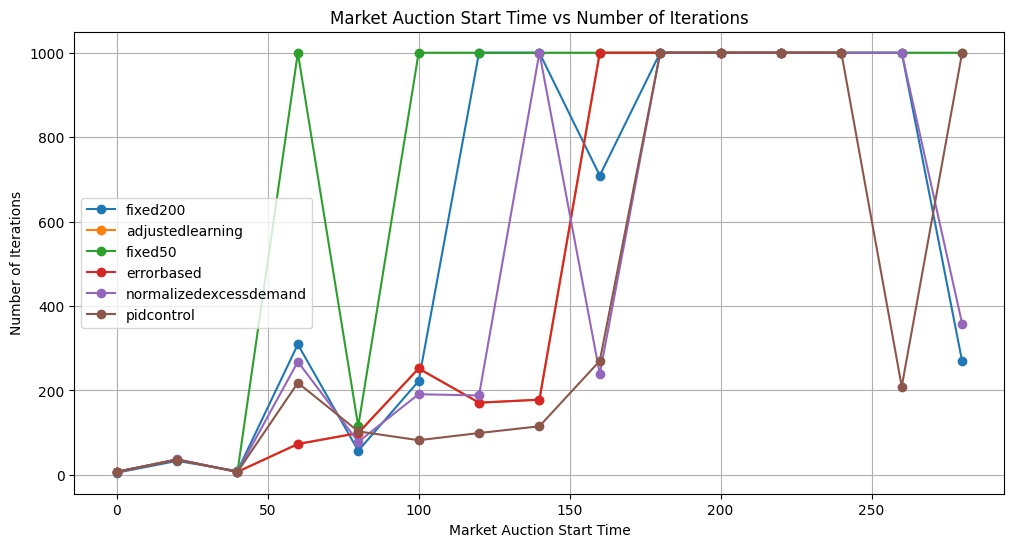

In [12]:
filtered_df = combined_df

# Filter the DataFrame based on the beta_method
# No filtering needed, keep all methods
# filtered_df = combined_df[combined_df["Beta_Method"] == beta_method
# Filter out the specified beta_method
beta_method_to_avoid = "excessdemand"
filtered_df = filtered_df[filtered_df["Beta_Method"] != beta_method_to_avoid]
# Plotting the data
plt.figure(figsize=(12, 6))
plt.title("Market Auction Start Time vs Number of Iterations")
plt.xlabel("Market Auction Start Time")
plt.ylabel("Number of Iterations")
plt.grid(True)

# filtered_df = filtered_df[filtered_df["Market_Auction_Start_Time"] <= 70]
for method in filtered_df["Beta_Method"].unique():
    subset = filtered_df[filtered_df["Beta_Method"] == method]
    plt.plot(subset["Market_Auction_Start_Time"], subset["Number_Interations"], label=method, marker='o')

plt.legend()
# plt.show()
plt.savefig(f"{current_dir}/plots/beta_method_niter.png")

# Alpha, studying tolerance (whisker plot)

In [ ]:
current_dir = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_dir, ".."))
new_folder_path = os.path.join(parent_folder, "results", "alpha_study")
folder_list = [f.path for f in os.scandir(new_folder_path) if f.is_dir()]


In [ ]:
df_list = []
df_method = []
for file in folder_list:
    folder_path = os.path.join(parent_folder, "results", file, "results")
    csv_file_path = os.path.join(folder_path, 'market_performance_table.csv')
    
    try:
        df_csv = pd.read_csv(csv_file_path)
        df_csv["File"] = file  # column to track file origin
        match = re.search(r"alpha-([^\s_]+)", file)
        alpha = match.group(1) if match else "Unknown"
        df_csv["alpha"] = alpha 
        df_list.append(df_csv)
    except FileNotFoundError:
        print(f"File not found: {csv_file_path}")
    except pd.errors.EmptyDataError:
        print(f"File is empty: {csv_file_path}")

# Concatenate all DataFrames
pd.set_option('display.max_rows', None) 

if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    display(combined_df)
else:
    print("No data was loaded.")

In [ ]:
filtered_df = combined_df
filtered_df['alpha'] = filtered_df['alpha'].astype(float)

alpha_values = sorted(filtered_df['alpha'].unique())
data = [filtered_df[filtered_df['alpha'] == alpha]['Number_Interations'].values for alpha in alpha_values]


plt.figure(figsize=(6, 6))
# plt.boxplot(data, positions=alpha_values, widths=0.1, patch_artist=True)
meanprops = dict(markeredgecolor='red', markersize=10, linestyle='-', linewidth=2, color='red')
plt.boxplot(data, positions=alpha_values, widths=0.25, showfliers=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            capprops=dict(color='blue'),
            whiskerprops=dict(color='blue'),
            flierprops=dict(color='blue', markeredgecolor='blue'),
            medianprops=meanprops)


# plt.boxplot(data, positions=alpha_values, widths= 0.25,  showfliers=False)
# Set x-axis ticks to match actual alpha values
# plt.xticks(alpha_values, labels=[str(alpha) for alpha in alpha_values])

plt.xticks(rotation=45)
plt.xlabel(r'Tolerance $\alpha$', fontsize=12)
plt.ylabel("Number of Iterations", fontsize=12)
# plt.xscale("log")  
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # Grid for better visualization

# Save the plot
plt.savefig(f"{current_dir}/plots/alpha_niter_boxplot.png")
plt.show()

# Lamba Study

In [ ]:
current_dir = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_dir, ".."))
new_folder_path = os.path.join(parent_folder, "results", "lambda")
folder_list = [f.path for f in os.scandir(new_folder_path) if f.is_dir()]

In [ ]:
df_list = []
df_method = []
for file in folder_list:
    folder_path = os.path.join(parent_folder, "results", file, "results")
    csv_file_path = os.path.join(folder_path, 'market_performance_table.csv')
    
    try:
        df_csv = pd.read_csv(csv_file_path)
        df_csv["File"] = file  # column to track file origin
        match = re.search(r"freq([^\s_]+)", file)
        lambda_val = match.group(1) if match else "Unknown"
        df_csv["Freq"] = lambda_val
        df_list.append(df_csv)
    except FileNotFoundError:
        print(f"File not found: {csv_file_path}")
    except pd.errors.EmptyDataError:
        print(f"File is empty: {csv_file_path}")

# Concatenate all DataFrames
pd.set_option('display.max_rows', None) 

if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    display(combined_df)
else:
    print("No data was loaded.")

In [ ]:
filtered_df = combined_df

plt.figure(figsize=(6, 6))

plt.xlabel("Frequency of Inner Loop Update (N)", fontsize=12)
plt.ylabel("Number of Iterations", fontsize=12)
plt.grid(True)
filtered_df = filtered_df.sort_values(by="Freq", key=lambda x: x.astype(float))

plt.plot(filtered_df["Freq"], filtered_df["Number_Interations"], marker='o')

# plt.show()
plt.savefig(f"{current_dir}/plots/lambda_niter.png")

# Percent/Number of drop-out vs Number of agents. 
### Read from result files the status of allocated

In [13]:
current_dir = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_dir, ".."))
new_folder_path = os.path.join(parent_folder, "results", "capacity_study")
folder_list = [f.path for f in os.scandir(new_folder_path) if f.is_dir()]
print(folder_list)

['/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap4_updated_fisher_b-50.0_agents80_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_185000', '/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap7_updated_fisher_b-50.0_agents177_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_210343', '/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap10_updated_fisher_b-50.0_agents10_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_161400', '/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap10_updated_fisher_b-50.0_agents120_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_161756', '/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_ca

In [ ]:

summary_data = {}

for folder in folder_list:
    # Construct the new folder path
    new_folder_path = os.path.join(folder, "results")
    results_table_path = os.path.join(new_folder_path, "market_results_table.csv")
    performance_table_path = os.path.join(new_folder_path, "market_performance_table.csv")
    
    try:
        df_results = pd.read_csv(results_table_path)
        df_performance = pd.read_csv(performance_table_path)
        
        # Extract the capacity value from the folder name
        capacity = int(folder.split('_cap')[1].split('_')[0])
        
        # Count each unique value under the column 'Status'
        status_counts = df_results['Status'].value_counts().to_dict()
        
        # Get the number of agents
        num_agents = df_performance['Number_Agents'].iloc[0]
        
        # Prepare column names specific to this file
        file_key = f"{folder}_cap{capacity}"
        
        # Store data in a dictionary format
        summary_data[file_key] = {
            'Capacity': capacity,
            'Number_Agents': num_agents,
            'Allocated': status_counts.get('allocated', 0),
            'Delayed': status_counts.get('delayed', 0),
            'Dropped': status_counts.get('dropped', 0),
            'Rebased': status_counts.get('rebased', 0),
            "Parked": status_counts.get('parked', 0)
        }
        
        # Add unknown status categories dynamically
        for status, count in status_counts.items():
            if status not in ["allocated", "delayed", "dropped", "rebased", "parked"]:
                summary_data[file_key][f"Unknown_{status}"] = count
                
        summary_data[file_key]['Check'] = (
            summary_data[file_key]['Allocated'] +
            summary_data[file_key]['Delayed'] +
            summary_data[file_key]['Dropped'] +
            summary_data[file_key]['Rebased'] +
            summary_data[file_key]['Parked'] == num_agents
        )
        
        summary_data[file_key]["Percentage_Allocated"] = summary_data[file_key]["Allocated"] / num_agents * 100
        summary_data[file_key]["Percentage_Delayed"] = summary_data[file_key]["Delayed"] / num_agents * 100
        summary_data[file_key]["Percentage_Dropped"] = summary_data[file_key]["Dropped"] / num_agents * 100
        summary_data[file_key]["Percentage_Rebased"] = summary_data[file_key]["Rebased"] / num_agents * 100
        summary_data[file_key]["Percentage_Parked"] = summary_data[file_key]["Parked"] / num_agents * 100
        summary_data[file_key]["perfect_dropped_rebased"] = (summary_data[file_key]["Dropped"] + summary_data[file_key]["Rebased"]) / num_agents * 100
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")
    except pd.errors.EmptyDataError as e:
        print(f"File is empty: {e}")

# Convert dictionary to DataFrame
if summary_data:
    df_status_summary = pd.DataFrame.from_dict(summary_data, orient='index')
    df_status_summary.fillna(0, inplace=True)
    display(df_status_summary)
else:
    print("No valid data collected.")


In [ ]:
# Plotting the percent of dropped/rebased vs number of agents
plt.figure(figsize=(6, 6))
plt.xlabel("Number of Agents", fontsize=12)
plt.ylabel("Percent of Unallocated Agents %", fontsize=12)
plt.grid(True)

# Plot each capacity

colors = {14: 'blue', 10: 'green', 7: 'orange', 4: 'red'}

df_status_summary = df_status_summary.sort_values(by=['Capacity', 'Number_Agents'])

for capacity in df_status_summary['Capacity'].unique():
    if capacity == 14:
        cap = 100
    elif capacity == 10:
        cap = 75
    elif capacity == 7:
        cap = 50
    elif capacity == 4:
        cap = 25
    subset = df_status_summary[df_status_summary['Capacity'] == capacity]
    # plt.plot(subset['Number_Agents'], subset['Percentage_Dropped'], label=f"Capacity {cap}%", marker='o', color=colors[capacity])
    # plt.plot(subset['Number_Agents'], subset['Percentage_Rebased'], label=f"Capacity {cap}%", marker='o', color=colors[capacity])
    # plt.plot(subset['Number_Agents'], subset['Percentage_Allocated'], label=f"Capacity {cap} Allocated", marker='s', color=colors[capacity])
    # plt.plot(subset['Number_Agents'], subset['Percentage_Delayed'], label=f"Capacity {cap} Delayed", marker='d', color=colors[capacity])
    plt.plot(subset['Number_Agents'], subset['Percentage_Rebased'], label=f"Capacity {cap}%", marker='o', color=colors[capacity])

plt.legend()
# plt.show()
plt.savefig(f"{current_dir}/plots/capacity_study_percentDropped.png")

## Percentage of Drops, parked, rebased, delayed in Beta Study, per auction.

In [14]:
current_dir = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_dir, ".."))
new_folder_path = os.path.join(parent_folder, "results", "beta_study_convergence")
folder_list = [f.path for f in os.scandir(new_folder_path) if f.is_dir()]
print(folder_list)

['/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/beta_study_convergence/toulouse_case_cap7_updated_20_fisher_b-200.0_agentsall_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_beta-method-fixed200_alpha-1.0_receding_20250323_162814', '/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/beta_study_convergence/toulouse_case_cap7_updated_20_fisher_b-50.0_agentsall_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_beta-method-adjustedlearning_alpha-1.0_receding_20250323_034655', '/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/beta_study_convergence/toulouse_case_cap7_updated_20_fisher_b-50.0_agentsall_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_beta-method-fixed50_alpha-1.0_receding_20250323_100157', '/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/beta_study_convergence/toulouse_case_cap7_updated_20_fisher_b-50.0_agentsall_dval40.0_outval1.0_pout1.0_freq30.0_pb


Aggregated Data:


,Beta_Method,Auction_Start_Time,Number_Agents,Allocated,Delayed,Dropped,Rebased,Parked
0,fixed200,180,10,6,4,0,19,0
1,fixed200,120,10,8,4,0,6,0
2,fixed200,80,10,10,2,0,3,0
3,fixed200,20,10,12,1,0,1,0
4,fixed200,0,10,10,0,0,0,0
5,fixed200,260,10,2,2,0,24,0
6,fixed200,60,10,11,0,0,6,0
7,fixed200,240,10,5,3,0,32,0
8,fixed200,160,10,7,5,0,15,0
9,fixed200,200,10,8,5,0,23,0


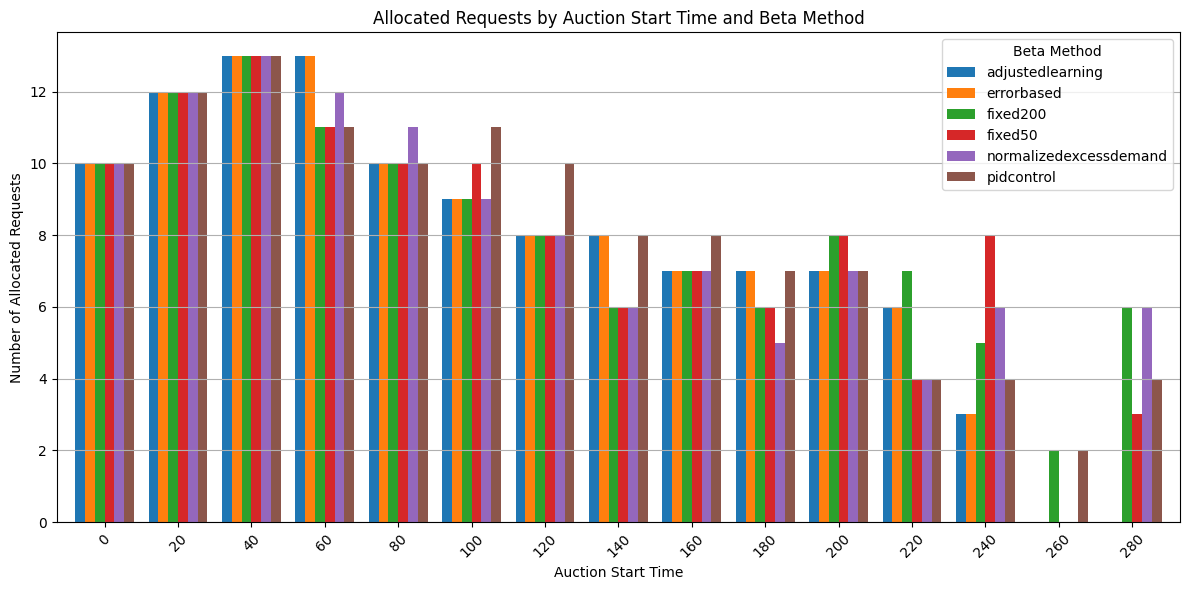

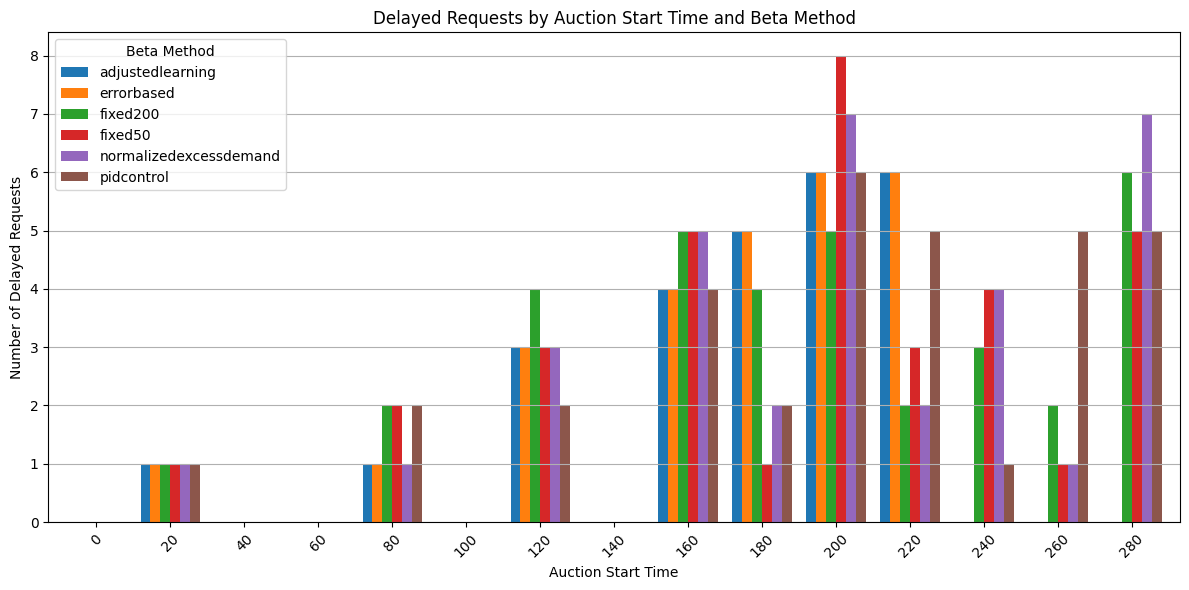

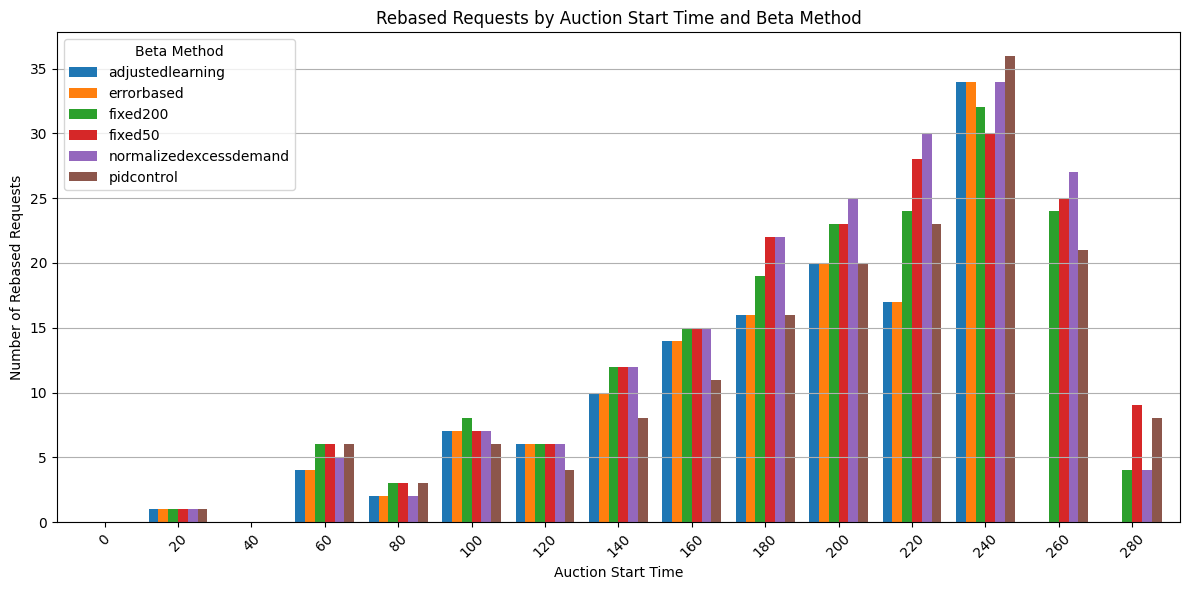

In [16]:
summary_data = []

for folder in folder_list:
    # Path containing the CSV files
    results_path = os.path.join(folder, "results")
    performance_table_path = os.path.join(results_path, "market_performance_table.csv")

    # Read performance table for the number of agents
    try:
        df_performance = pd.read_csv(performance_table_path)
        num_agents = df_performance['Number_Agents'].iloc[0]
    except (FileNotFoundError, pd.errors.EmptyDataError):
        num_agents = None

    if os.path.isdir(results_path):
        for file in os.listdir(results_path):
            # Match files named "results_table_XXX.csv"
            match_auction = re.match(r"results_table_(\d+)\.csv", file)
            if match_auction:
                auction_start_time = int(match_auction.group(1))
                csv_file_path = os.path.join(results_path, file)

                try:
                    df_results = pd.read_csv(csv_file_path)
                except (FileNotFoundError, pd.errors.EmptyDataError):
                    continue

                # Extract beta method from file name
                match_beta = re.search(r"beta-method-([^\s_]+)", folder)
                beta_method = match_beta.group(1) if match_beta else "Unknown"

                # Count status occurrences
                if 'Status' in df_results.columns:
                    status_counts = df_results['Status'].value_counts().to_dict()
                else:
                    continue

                # Store the results in a list of dictionaries
                summary_data.append({
                    'Beta_Method': beta_method,
                    'Auction_Start_Time': auction_start_time,
                    'Number_Agents': num_agents if num_agents else 0,
                    'Allocated': status_counts.get('allocated', 0),
                    'Delayed': status_counts.get('delayed', 0),
                    'Dropped': status_counts.get('dropped', 0),
                    'Rebased': status_counts.get('rebased', 0),
                    'Parked': status_counts.get('parked', 0)
                })

# Convert list of dictionaries to DataFrame
df_summary = pd.DataFrame(summary_data)

# df_summary = df_summary[df_summary["Auction_Start_Time"] <= 70]
if df_summary.empty:
    print("No valid data collected.")
else:
    print("\nAggregated Data:")
    display(df_summary)

    # Filter out specific beta methods if needed
    beta_method_to_avoid = "excessdemand"
    df_filtered = df_summary[df_summary["Beta_Method"] != beta_method_to_avoid]

    # -----------------------
    # Bar Plot: "Dropped" vs Auction Start Time
    # -----------------------
    # pivot_dropped = df_filtered.pivot(index="Auction_Start_Time", columns="Beta_Method", values="Dropped")
    # pivot_dropped.plot(kind='bar', figsize=(12, 6), width=0.8)
    # plt.title("Dropped Requests by Auction Start Time and Beta Method")
    # plt.xlabel("Auction Start Time")
    # plt.ylabel("Number of Dropped Requests")
    # plt.grid(axis='y')
    # plt.legend(title="Beta Method")
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.savefig(f"{current_dir}/plots/dropped_by_beta_method.png")
    # plt.show()

    # -----------------------
    # Bar Plot: "Allocated" vs Auction Start Time
    # -----------------------
    pivot_allocated = df_filtered.pivot(index="Auction_Start_Time", columns="Beta_Method", values="Allocated")
    pivot_allocated.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.title("Allocated Requests by Auction Start Time and Beta Method")
    plt.xlabel("Auction Start Time")
    plt.ylabel("Number of Allocated Requests")
    plt.grid(axis='y')
    plt.legend(title="Beta Method")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{current_dir}/plots/allocated_by_beta_method.png")
    plt.show()

    # -----------------------
    # Bar Plot: "Delayed" vs Auction Start Time
    # -----------------------
    pivot_delayed = df_filtered.pivot(index="Auction_Start_Time", columns="Beta_Method", values="Delayed")
    pivot_delayed.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.title("Delayed Requests by Auction Start Time and Beta Method")
    plt.xlabel("Auction Start Time")
    plt.ylabel("Number of Delayed Requests")
    plt.grid(axis='y')
    plt.legend(title="Beta Method")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{current_dir}/plots/delayed_by_beta_method.png")
    plt.show()

    # -----------------------
    # Bar Plot: "Rebased" vs Auction Start Time
    # -----------------------
    pivot_rebased = df_filtered.pivot(index="Auction_Start_Time", columns="Beta_Method", values="Rebased")
    pivot_rebased.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.title("Rebased Requests by Auction Start Time and Beta Method")
    plt.xlabel("Auction Start Time")
    plt.ylabel("Number of Rebased Requests")
    plt.grid(axis='y')
    plt.legend(title="Beta Method")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{current_dir}/plots/rebased_by_beta_method.png")
    plt.show()